In [3]:
import datetime
from dateutil.parser import parse

import getpass

from IPython.core.display import display, HTML

import numpy as np
from pandas import pandas
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

from storyboardclient.v1 import client
api_url="https://storyboard.openstack.org/api/v1"

#display(HTML('Get a token from: <a href="https://storyboard.openstack.org/#!/profile/tokens">https://storyboard.openstack.org/#!/profile/tokens</a></body>'))
print('https://storyboard.openstack.org/#!/profile/tokens')
access_token = getpass.getpass('Enter token:')

storyboard = client.Client(api_url, access_token)

https://storyboard.openstack.org/#!/profile/tokens


Enter token: ····································


In [4]:
%%time

# Get all stories
stories = storyboard.stories.get_all()
print('Number of stories', len(stories))

# Get all tasks
tasks = storyboard.tasks.get_all()
print('Number of tasks', len(tasks))

# get all users
users = storyboard.users.get_all()
print('Number of users', len(users))

Number of stories 27872
Number of tasks 38365
Number of users 6769
CPU times: user 7.69 s, sys: 523 ms, total: 8.21 s
Wall time: 1min 37s


In [5]:
# Create dicts for stories, tasks and users
users_dict = {}
for u in users:
    users_dict[u.id] = u.to_dict() 

stories_dict = {}
stories_objects_dict = {}
for s in stories:
    stories_dict[s.id] = s.to_dict()
    stories_objects_dict[s.id] = s
    if s.creator_id is None:
        stories_dict[s.id]['creator_name'] = 'UNKNOWN'
    else:
        stories_dict[s.id]['creator_name'] = users_dict[s.creator_id]['full_name']

tasks_dict = {}
for t in tasks:
    tasks_dict[t.id] = t.to_dict()
    if t.creator_id is None:
        tasks_dict[t.id]['creator_name'] = stories_dict[t.story_id]['creator_name']
    else:
        tasks_dict[t.id]['creator_name'] = users_dict[t.creator_id]['full_name']
    if t.assignee_id is None:
        tasks_dict[t.id]['assignee_name'] = 'UNKNOWN'
    else:
        tasks_dict[t.id]['assignee_name'] = users_dict[t.assignee_id]['full_name']
    tasks_dict[t.id]['story_updated_at'] = stories_dict[t.story_id]['updated_at']
    tasks_dict[t.id]['story_url'] = 'https://storyboard.openstack.org/#!/story/' + str(t.story_id)

In [214]:
#stories_dict[2006738]

In [215]:
#tasks_dict[1]

In [6]:
# Get the project group to work with
project_group_name = 'magnum'

project_group = storyboard.project_groups.find(name=project_group_name)

project_ids = [ project.id for project in project_group.projects.list() ]
project_names = [ project.name for project in project_group.projects.list() ]
projects = {}
for project in project_group.projects.list():
    projects[project.id] = project.name


In [13]:
def histogram_of_tasks(tasks):
    task_counts = {}
    for pn in project_names:
        task_counts[pn] = {}
    for t in tasks_in_group:
        project_name = projects[t['project_id']]
        task_counts[project_name][t['status']] = task_counts[project_name].get(t['status'], 0) + 1
    return task_counts

def print_task_with_url_html(task_id):
    task = tasks_dict[task_id]
    story_id = tasks_dict[task_id]['story_id']
    story_title = stories_dict[story_id]['title']
    msg = str(task_id)
    msg += ' <a href="https://storyboard.openstack.org/#!/story/'
    msg += str(story_id) + '">' + story_title + '</a></body>'
    display(HTML(msg))

def print_task_with_url(task_id):
    task = tasks_dict[task_id]
    story_id = tasks_dict[task_id]['story_id']
    story_title = stories_dict[story_id]['title']
    story_updated = stories_dict[story_id]['updated_at']
    msg = str(task_id) + ' ' + ' https://storyboard.openstack.org/#!/story/' + str(story_id) + ' ' + story_title
    print(msg)

def print_story_with_url(story_id):
    story_title = stories_dict[story_id]['title']
    msg = str(story_id)
    msg += ' <a href="https://storyboard.openstack.org/#!/story/'
    msg += str(story_id) + '">' + story_title + '</a></body>'
    display(HTML(msg))
    
def is_task_open(id):
    if tasks_dict[id]['status'] not in ['invalid', 'merged']:
        return True
    else:
        return False

def days_since_updated(id):
    if id in stories_dict:
        story_id = id
    else:
        story_id = tasks_dict[id]['story_id']

    updated_at = parse(stories_dict[story_id]['updated_at']).replace(tzinfo=None)
    now = datetime.datetime.now().replace(tzinfo=None)
    delta = now - updated_at
    return delta.days

def mark_task_invalid(task_id):
    storyboard.tasks.update(id=task_id, status='invalid')

def comment_story_for_invalid_task(task_id, comment_content):
    t = tasks_dict[task_id]
    s = stories_objects_dict[t.story_id]
    msg =   'This is an automated message.'
    msg += ' This story has not been updated in the last 360 days.'
    msg += ' Per discussion on the magnum meeting of 2020-05-13, we marks task:'
    msg += ' ' + str(task_id)
    msg += ' as invalid.'
    msg += 'Feel free to mark as todo any task in this story or add new ones.'
    s.comments.create(content=comment_content)

#storyboard.tasks.update(id=39459, status='todo')
#s.comments.create(content='foo')

In [14]:
# Get all tasks affecting the above project group
tasks_in_group = []
tasks_in_group_dict = {}

for t in tasks:
    if t.project_id in project_ids:
        tasks_in_group.append(tasks_dict[t.id])
        tasks_in_group_dict[t.id] = tasks_dict[t.id]
print('all tasks:', len(tasks_in_group))

open_tasks_in_group = []
open_tasks_in_group_dict = {}
for t in tasks_in_group:
    if is_task_open(t['id']):
        open_tasks_in_group.append(t)
        open_tasks_in_group_dict[t['id']] = t
print('open tasks:', len(open_tasks_in_group))

all tasks: 2397
open tasks: 389


Active   tasks not updated in the last 360 days: 284
Active Stories not updated in the last 360 days: 277


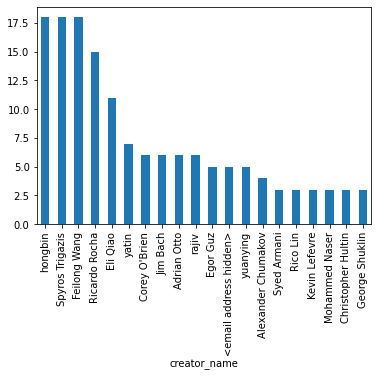

In [15]:
d = {}
days_since_updated_th = 360
active_stories = {}
for id, t in open_tasks_in_group_dict.items():
    if days_since_updated(id) > days_since_updated_th:
        d[id] = t
        active_stories[t['story_id']] = stories_dict[t['story_id']]
print('Active   tasks not updated in the last', days_since_updated_th, 'days:', len(d.keys()))
print('Active Stories not updated in the last', days_since_updated_th, 'days:', len(active_stories.keys()))

df = pandas.DataFrame.from_dict(active_stories, orient='index')
df_grouped = df.groupby(['creator_name'])['id'].count()
df2 = df_grouped.sort_values(ascending=False)
df2.head(20).plot.bar()

In [16]:
df2

creator_name
hongbin                    18
Spyros Trigazis            18
Feilong Wang               18
Ricardo Rocha              15
Eli Qiao                   11
yatin                       7
Corey O'Brien               6
Jim Bach                    6
Adrian Otto                 6
rajiv                       6
Egor Guz                    5
<email address hidden>      5
yuanying                    5
Alexander Chumakov          4
Syed Armani                 3
Rico Lin                    3
Kevin Lefevre               3
Mohammed Naser              3
Christopher Hultin          3
George Shuklin              3
PanFengyun                  3
Prateek khushalani          2
Dimitry Ushakov             2
Hua Wang                    2
Mark Goddard                2
HouMing Wang                2
Mathieu Velten              2
Lingxian Kong               2
Grzegorz Bialas             2
Thomas Hartland             2
Guang Yee                   2
Michal Jura                 2
OpenStack Infra            

In [17]:
#df = pandas.DataFrame.from_dict(active_stories, orient='index')

for task_id, t in d.items():
    print_task_with_url(task_id)

20117  https://storyboard.openstack.org/#!/story/1543308 We must not disable selinux
20138  https://storyboard.openstack.org/#!/story/1718947 Limit the name of the Instance names
20159  https://storyboard.openstack.org/#!/story/1422831 Error on deleting volume on bay update
20192  https://storyboard.openstack.org/#!/story/1489908 Tech-Debt: Add tests for DB migration
20207  https://storyboard.openstack.org/#!/story/1539527 magnum service-list no response if m-cond is down
20209  https://storyboard.openstack.org/#!/story/1556000 Find an alternative way to replace WSME library
20216  https://storyboard.openstack.org/#!/story/1568018 Stable liberty seems to fail tests
20244  https://storyboard.openstack.org/#!/story/1704329 Clluster creation failed because of failure in getting etcd discovery url 
20247  https://storyboard.openstack.org/#!/story/1752433 trust invalid when user is disabled
20276  https://storyboard.openstack.org/#!/story/1477444 document how to setup magnum api with apache

In [18]:
# mark old tasks as invalid
d = {}
days_since_updated_th = 360
active_stories = {}
for id, t in open_tasks_in_group_dict.items():
    if days_since_updated(id) > days_since_updated_th:
        d[id] = t
        active_stories[t['story_id']] = stories_dict[t['story_id']]
print(len(d.keys()))

284
